# Introduction to dMRI data

In [1]:
import warnings

warnings.filterwarnings("ignore")

from IPython.display import HTML

Diffusion imaging probes the random, microscopic movement of water molecules by using MRI sequences that are sensitive to the geometry and environmental organization surrounding these protons.
This is a popular technique for studying the white matter of the brain.
The diffusion within biological structures, such as the brain, are often restricted due to barriers (e.g., cell membranes), resulting in a preferred direction of diffusion (anisotropy).
A typical dMRI scan will acquire multiple volumes (or ***angular samples***), each sensitive to a particular ***diffusion direction***.

In [2]:
HTML("""<video loop="yes" muted="yes" autoplay="yes" controls="yes"><source src="../videos/dMRI-signal-movie.mp4" type="video/mp4"/></video>""")

*Sourced from Dr. A. Rokem, DIPY Workshop 2021*

These *diffusion directions* (or ***orientations***) are a fundamental piece of metadata to interpret dMRI data, as models need to know the exact orientation of each angular sample.

```{admonition} Main elements of a dMRI dataset
- A 4D data array, where the last dimension encodes the reconstructed **diffusion direction *maps***.
- Tabular data or a 2D array, listing the **diffusion directions** (`.bvec`) and the encoding **gradient strength** (`.bval`).
```

In summary, dMRI involves ***complex data types*** that, as programmers, we want to access, query and manipulate with ease.

## Python and object oriented programming

Python is an [object oriented programming](https://en.wikipedia.org/wiki/Object-oriented_programming) language.
It allows us to represent and encapsulate data types and corresponding behaviors into programming structures called *objects*.

```{admonition} Data structures
How you feed in data into your algorithm will impose constraints that might completely hinder the implementation of nonfunctional requirements down the line.
Therefore, a careful plan must also be thought out for the data structures we are going to handle.
```

Therefore, let's leverage Python to create *objects* that contain dMRI data.
In Python, *objects* can be specified by defining a class.
In the example code below, we've created a class with the name `DWI`.
To simplify class creation, we've also used the magic of a Python library called [`attrs`](https://www.attrs.org/en/stable/).

In [3]:
"""Representing data in hard-disk and memory."""
import attr

def _data_repr(value):
    if value is None:
        return "None"
    return f"<{'x'.join(str(v) for v in value.shape)} ({value.dtype})>"


@attr.s(slots=True)
class DWI:
    """Data representation structure for dMRI data."""

    dataobj = attr.ib(default=None, repr=_data_repr)
    """A numpy ndarray object for the data array, without *b=0* volumes."""
    brainmask = attr.ib(default=None, repr=_data_repr)
    """A boolean ndarray object containing a corresponding brainmask."""
    bzero = attr.ib(default=None, repr=_data_repr)
    """A *b=0* reference map, preferably obtained by some smart averaging."""
    gradients = attr.ib(default=None, repr=_data_repr)
    """A 2D numpy array of the gradient table in RAS+B format."""
    em_affines = attr.ib(default=None)
    """
    List of :obj:`nitransforms.linear.Affine` objects that bring
    DWIs (i.e., no b=0) into alignment.
    """

    def __len__(self):
        """Obtain the number of high-*b* orientations."""
        return self.gradients.shape[-1]

This code implements several *attributes* as well as a *behavior* - the `__len__` *method*.
The `__len__` method is special in Python, as it will be executed when we call the built-in function `len()` on our object.

Let's test out the `DWI` data structure with some *simulated* data:

In [4]:
# NumPy is a fundamental Python library for working with arrays
import numpy as np

# create a new DWI object, with only gradient information that is random
dmri_dataset = DWI(gradients=np.random.normal(size=(4, 64)))

# call Python's built-in len() function
print(len(dmri_dataset))

64


The output of this `print()` statement is telling us that this (simulated) dataset has 64 diffusion-weighted samples.

## Using the new data representation object

The code shown above was just a snippet of the `DWI` class. For simplicity, we will be using the full implementation of this class from our [`eddymotion` package](https://github.com/nipreps/EddyMotionCorrection/blob/main/eddymotion/dmri.py)
Under the `data/` folder of this book's distribution, we have stored a sample DWI dataset with filename `dwi.h5`.
Please note that the file has been minimized by zeroing all but two diffusion-weighted orientation maps.

Let's get some insights from it:

In [5]:
# import the class from the library
from eddymotion.data.dmri import DWI

# load the sample file
dmri_dataset = DWI.from_filename("../../data/dwi.h5")
print(len(dmri_dataset))

102


In this case, the dataset is reporting to have 102 diffusion-weighted samples.

Python will automatically generate a summary of this object if we just type the name of our new object.
This pretty-printing of the object informs us about the data and metadata that, together, compose this particular DWI dataset:

In [6]:
dmri_dataset

DWI(dataobj=<118x118x78x102 (int16)>, affine=<4x4 (float64)>, brainmask=None, bzero=<118x118x78 (int16)>, gradients=<4x102 (float32)>, em_affines=None, fieldmap=None)

We'll go over some of the components of `dmri_dataset` through this lesson.

## Visualizing the data

````{admonition} Exercise
Let's start out by seeing what the data looks like.
The fully-fledged `DWI` object has a convenience function to plot the dataset.

```{hint}
To see all of the instances and behaviors available to an object, try typing the object name, followed by `.` and <kbd>Tab</kbd>
```

````

**Solution**

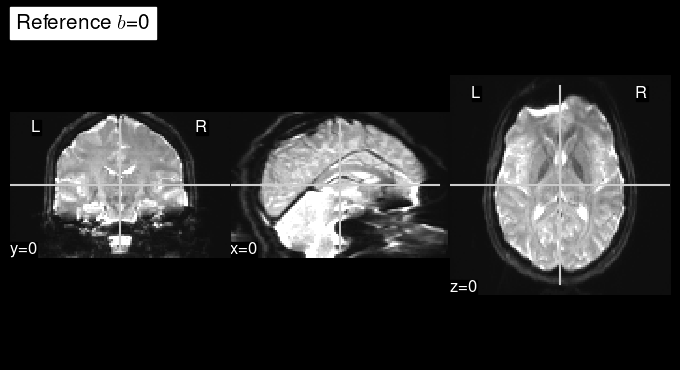

In [7]:
dmri_dataset.plot_mosaic();

When calling `plot_mosaic()` without any arguments, the *b=0* reference is plotted.
This *b=0* reference is a map of the signal measured ***without gradient sensitization***, or in other words, when we are not measuring diffusion in any direction.
The *b=0* map can be used by diffusion modeling as the reference to quantify the signal drop at every voxel and given a particular orientation gradient.

We can also get some insight into how a particular diffusion-weighted orientation looks like by selecting them with the argument `index`.

```{admonition} Exercise
Try calling `plot_mosaic` with an index of 10 or 100.
```

**Solution**

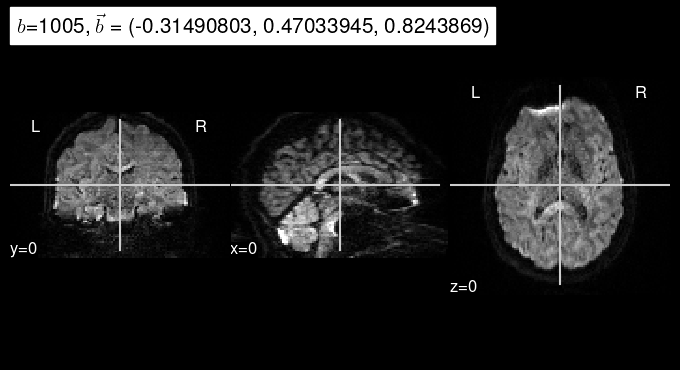

In [8]:
dmri_dataset.plot_mosaic(index=10, vmax=5000);

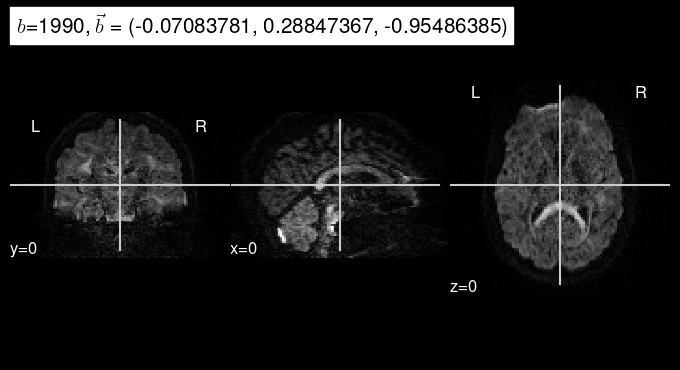

In [9]:
dmri_dataset.plot_mosaic(index=100, vmax=5000);

Diffusion that exhibits directionality in the same direction as the gradient results in a loss of signal.
As we can see, ***diffusion-weighted*** images consistently drop almost all signal in voxels filled with cerebrospinal fluid because there, water diffusion is free (isotropic) regardless of the direction that is being measured.

We can also see that the images at `index=10` and `index=100` have different gradient strength ("*b-value*").
The higher the magnitude of the gradient, the more diffusion that is allowed to occur, indicated by the overall decrease in signal intensity.
Stronger gradients yield diffusion maps with substantially lower SNR (signal-to-noise ratio), as well as larger distortions derived from the so-called "*Eddy-currents*".

## Visualizing the gradient information

Our `DWI` object stores the gradient information in the `gradients` attribute.

```{admonition} Exercise
Let's see the shape of the gradient information.
```

**Solution**

In [10]:
dmri_dataset.gradients.shape

(4, 102)

We get a $4\times102$ -- three spatial coordinates ($b_x$, $b_y$, $b_z$) of the unit-norm "*b-vector*", plus the gradient sensitization magnitude (the "*b-value*"), with a total of 102 different orientations for the case at hand.

```{admonition} Exercise
Try printing the gradient information to see what it contains.
Remember to transpose (`.T`) the array.
```

**Solution**

In [11]:
print(dmri_dataset.gradients.T)

[[-6.04914188e-01 -6.79875135e-01 -4.14546251e-01  3.00000000e+02]
 [ 7.51762651e-03  9.17056799e-01 -3.98685753e-01  3.00000000e+02]
 [-8.86579394e-01  3.21218759e-01 -3.32859576e-01  3.00000000e+02]
 [ 8.16364467e-01  2.68300444e-01 -5.11433184e-01  3.00000000e+02]
 [ 4.34362024e-01 -7.33946085e-01 -5.22161603e-01  3.00000000e+02]
 [ 9.60559174e-02 -7.31587410e-02  9.92683768e-01  3.05000000e+02]
 [ 5.85605621e-01  7.62755051e-02  8.06999445e-01  1.00500000e+03]
 [ 1.32749856e-01  3.81094962e-01 -9.14955795e-01  9.95000000e+02]
 [-9.10080016e-01  3.49084914e-01  2.23369867e-01  1.00000000e+03]
 [-1.42672375e-01 -9.87846315e-01 -6.16788231e-02  1.00000000e+03]
 [-3.14908028e-01  4.70339447e-01  8.24386895e-01  1.00500000e+03]
 [ 9.26234543e-01  3.46899480e-01 -1.47479758e-01  1.00000000e+03]
 [ 6.95218086e-01  6.17206156e-01 -3.68413389e-01  9.95000000e+02]
 [ 1.79834515e-01 -9.48279917e-01  2.61581242e-01  1.00000000e+03]
 [-5.72267652e-01  8.19448650e-01 -3.18384580e-02  1.00000000e

Later, we'll refer to this array as the gradient table.

It consists of one row per diffusion-weighted image, with each row consisting of 4 values corresponding to [ R A S+ b ].

[ R A S+ ] are the components of the **gradient direction**.
Note that the directions have been re-oriented with respect to *world space coordinates*.
For more information on this, refer to {doc}`the Affine section in The extra mile <../extra/nifti>`.

The last column, b, reflects the **timing and strength of the gradients** in units of s/mm².

To get a better sense of which gradient directions were sampled, let's plot them!

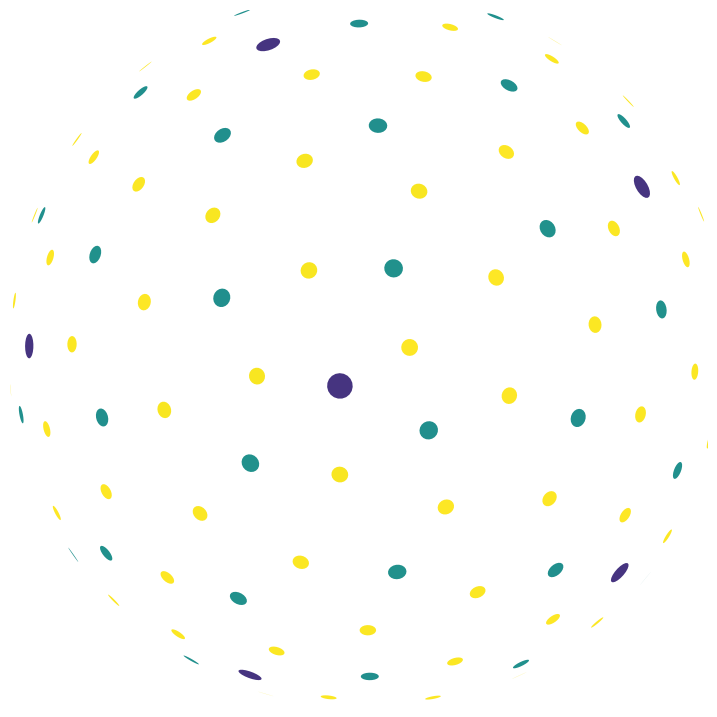

In [12]:
dmri_dataset.plot_gradients();


We've projected all of the gradient directions onto the surface of a sphere, with each unique gradient strength colour-coded.
Darkest hues correspond to the lowest *b*-values and brighter to the highest.

## The *LOGO* (leave-one-gradient-out) splitter

One final behavior that will make our endeavor easier in the long run is a convenience method for data splitting.
In particular, we are implementing some sort of cross-validation scheme where we will iterate over different data splits.
In this case, the splitting strategy is a simple leave-one-out.
Because one "*datapoint*" in our DWI dataset corresponds to one gradient, we will refer to this partitioning of the dataset as *leave-one-gradient-out (LOGO)*:

In [13]:
def logo_split(self, index, with_b0=False):
    """
    Produce one fold of LOGO (leave-one-gradient-out).

    Parameters
    ----------
    index : :obj:`int`
        Index of the DWI orientation to be left out in this fold.
    with_b0 : :obj:`bool`
        Insert the *b=0* reference at the beginning of the training dataset.

    Return
    ------
    (train_data, train_gradients) : :obj:`tuple`
        Training DWI and corresponding gradients.
        Training data/gradients come **from the updated dataset**.
    (test_data, test_gradients) :obj:`tuple`
        Test 3D map (one DWI orientation) and corresponding b-vector/value.
        The test data/gradient come **from the original dataset**.

    """
    dwframe = self.dataobj[..., index]
    bframe = self.gradients[..., index]

    # if the size of the mask does not match data, cache is stale
    mask = np.zeros(len(self), dtype=bool)
    mask[index] = True

    train_data = self.dataobj[..., ~mask]
    train_gradients = self.gradients[..., ~mask]

    if with_b0:
        train_data = np.concatenate(
            (np.asanyarray(self.bzero)[..., np.newaxis], train_data),
            axis=-1,
        )
        b0vec = np.zeros((4, 1))
        b0vec[0, 0] = 1
        train_gradients = np.concatenate(
            (b0vec, train_gradients),
            axis=-1,
        )

    return (
        (train_data, train_gradients),
        (dwframe, bframe),
    )

This function is contained in the `DWI` class shown earlier and will allow us to easily partition the dataset as follows:

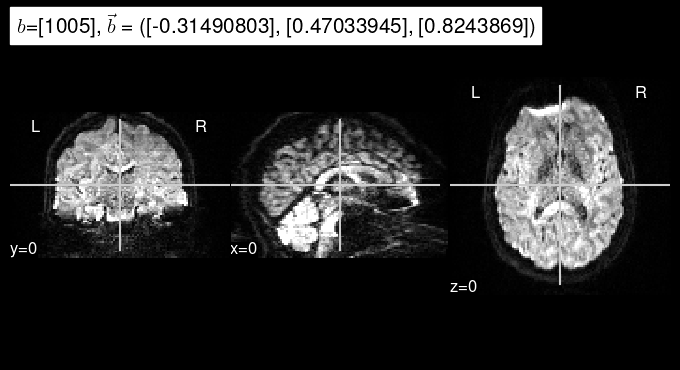

In [14]:
from eddymotion.data.splitting import lovo_split as logo_split
from eddymotion.viz import plot_dwi

data_train, data_test = logo_split(dmri_dataset, 10)
plot_dwi(np.squeeze(data_test[0]), dmri_dataset.affine, gradient=data_test[1]);

`data_train` is a tuple containing all diffusion-weighted volumes and the corresponding gradient table, excluding the left-out, which is stored in `data_test` (the 11<sup>th</sup> gradient indexed by `10`, in this example).
`data_test[0]` contains the held-out diffusion-weighted volume and `data_test[1]`, the corresponding gradient table.

```{admonition} Exercise
Try printing the shapes of elements in the `data_train` tuple.
```

**Solution**

In [15]:
print(f"data_train[0] is the DW maps dataset and has {data_train[0].shape} dimensions")
print(f"data_train[1] is a gradient table and has {data_train[1].shape} dimensions")

data_train[0] is the DW maps dataset and has (118, 118, 78, 101) dimensions
data_train[1] is a gradient table and has (4, 101) dimensions


```{admonition} Exercise
Likewise for the left-out gradient, try printing the shapes of elements in the `data_test` tuple.
```

**Solution**

In [16]:
print(f"data_test[0] is left-out DW map and has {data_test[0].shape} dimensions")
print(f"data_test[1] is the corresponding DW gradient and has {data_test[1].shape} dimensions")

data_test[0] is left-out DW map and has (118, 118, 78, 1) dimensions
data_test[1] is the corresponding DW gradient and has (4, 1) dimensions


## Next steps: diffusion modeling

By modeling the diffusion signal, the acquired images can provide measurements which are related to the microscopic changes and estimate white matter trajectories.